# Setup

In [1]:
%cd /Users/edoardorossi/Documents/GitHub/Last_tesi
PROJECT_PATH = '/Users/edoardorossi/Documents/GitHub/Last_tesi'
CTA30_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('functions'))
sys.path.insert(0, os.path.abspath(''))
warnings.filterwarnings('ignore')
#from functions.pkl import store_data, load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.optimize import differential_evolution
import random
from collections import defaultdict
import time
import itertools
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

def store_data(data, file_name):
    dbfile = open(file_name, 'ab')
    pickle.dump(data, dbfile)
    dbfile.close()
  
def load_data(file_name):
    dbfile = open(file_name, 'rb')
    db = pickle.load(dbfile)
    dbfile.close()
    return db


print("Libraries imported")

/Users/edoardorossi/Documents/GitHub/Last_tesi


2023-07-14 16:01:20.439407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Import DF

In [2]:
cta30_def_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)

try:
    df = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'))
    df_a = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'))
    df_rew = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv')) 
    
except:
    cta30_18_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
    cta30_19_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
    cta30_20_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
    cta30_21_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
    cta30_22_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

    df18= pd.read_csv(cta30_18_path)
    df19= pd.read_csv(cta30_19_path)
    df20= pd.read_csv(cta30_20_path)
    df21= pd.read_csv(cta30_21_path)
    df22= pd.read_csv(cta30_22_path)

    df_complete = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

    #drop le colonne 'F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00' 
    df = df_complete.drop(['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)
    # create df_a with only dropped columns
    df_a = df_complete[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]


    df_a['VLV_RAF_REG_00'] = df_a['VLV_RAF_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)
    df_a['VLV_SUR_REG_00'] = df_a['VLV_SUR_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)

    df_a['VLV'] = 0 # colonna inizializzata a 0
    for i in range(len(df)):
        if df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] == 0:
            df_a.loc[i, 'VLV'] = 0
        elif df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] != 0:
            df_a.loc[i, 'VLV'] = -1
        elif df_a['VLV_RAF_REG_00'][i] != 0 and df_a['VLV_SUR_REG_00'][i] == 0:
            df_a.loc[i, 'VLV'] = 1

    df_a = df_a.drop(['VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)

    df_rew = df_complete[['T_AMB_00', 'T_AMB_01', 'T_AMB_02', 'T_AMB_03', 'PW_ATT_M_00', 'T_M_SP_00']]

    #df_rew.to_csv(os.path.join(PROJECT_PATH, 'df_rew.csv'), index=False)     

    #print shapes of df and df_a and df_rew
    print('df shape: ', df.shape)
    print('df_a shape: ', df_a.shape)
    print('df_rew shape: ', df_rew.shape)

    df.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'), index=False)
    df_a.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'), index=False)
    df_rew.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv'), index=False)




## Normalization

In [3]:
path_scale_norm ='DQN_data/scaler_norm.pkl'
scaler_path = os.path.join(PROJECT_PATH, path_scale_norm)
print(scaler_path)
try: 
    scale_norm = load_data(scaler_path)
    df_norm = pd.DataFrame(scale_norm.transform(df), columns=df.columns)
    print("Normalization loaded")
except:
    print("Computing normalization")
    scale_norm = MinMaxScaler()
    df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)
    store_data(scale_norm, scaler_path)

print("The dataset has", df_norm.shape[1], "columns after normalization")

path_pca_norm = 'DQN_data/pca_norm.pkl'
pca_model_path = os.path.join(PROJECT_PATH, path_pca_norm)
print(pca_model_path)
try:
    pca = load_data(pca_model_path)
    pca_norm = pd.DataFrame(pca.transform(df_norm))
    print("PCA loaded")
except:
    print("Computing PCA")
    pca = PCA(n_components=0.9)
    pca_norm = pd.DataFrame(pca.fit_transform(df_norm))
    store_data(pca, pca_model_path)
    print("PCA computed")
print("The dataset has", pca_norm.shape[1], "columns after PCA")

df_a_norm = pd.DataFrame(scale_norm.fit_transform(df_a), columns=df_a.columns)




/Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data/scaler_norm.pkl
Computing normalization
The dataset has 73 columns after normalization
/Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data/pca_norm.pkl
PCA loaded
The dataset has 7 columns after PCA


## Action - F: KMeans

In [4]:
DQN_path = 'DQN_data'
folder_name = 'action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, DQN_path, folder_name)
os.makedirs(folder_path, exist_ok=True)
print(folder_path)

X = df_a_norm['F_M_FDBK_00'].values.reshape(-1,1)
k_min = 2
k_max = 10
step = 1


n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    # se il file è presente in PROJECT_PATH/DQN_path/folder_name non lo ricalcolo
    file_path = os.path.join(folder_path, f'kmeans_{n_clusters}.pkl')
    if os.path.isfile(file_path):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        print(file_path)
        with open(file_path, 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

/Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data/action_f_fit_norm
kmeans_2.pkl already exists
kmeans_3.pkl already exists
kmeans_4.pkl already exists
kmeans_5.pkl already exists
kmeans_6.pkl already exists
kmeans_7.pkl already exists
kmeans_8.pkl already exists
kmeans_9.pkl already exists
kmeans_10.pkl already exists


lista file: 
 ['kmeans_2.pkl', 'kmeans_3.pkl', 'kmeans_4.pkl', 'kmeans_5.pkl', 'kmeans_6.pkl', 'kmeans_7.pkl', 'kmeans_8.pkl', 'kmeans_9.pkl', 'kmeans_10.pkl']


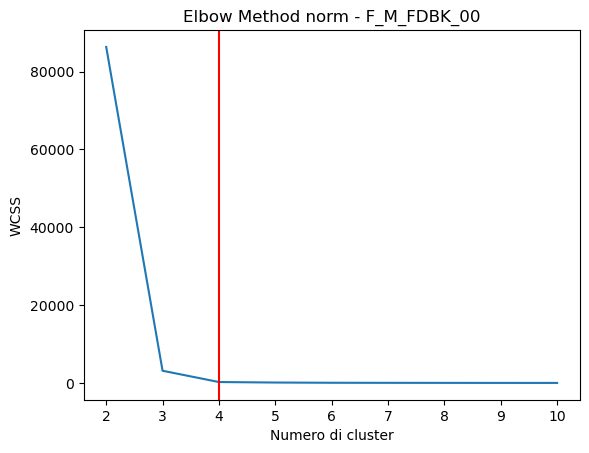

[[9.59514073e-06]
 [4.96453165e-01]
 [9.96612063e-01]
 [3.39540659e-01]]
[2 2 2 ... 0 0 0]
241.46819710986992
1
4
300


In [5]:
# ELBOW graph

from math import log
DQN_path = 'DQN_data'
folder_name = 'action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, DQN_path, folder_name)
os.makedirs(folder_path, exist_ok=True)
file_list = os.listdir(folder_path)

def ordina_file_per_numero(nome_file):
    prefisso = "kmeans_"
    suffisso = ".pkl"
    numero_str = nome_file[len(prefisso):-len(suffisso)]
    numero = int(numero_str)
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

x = []
y = []

print('lista file: \n', file_list_ordinata)

for i in range(len(file_list_ordinata)):

    # carica il file pkl
    with open(os.path.join(folder_path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)
    
    #esegui la fit su pca_norm 
    #modello.fit(X)

    #assegna alla variabile x il numero di cluster
    x.append(modello.n_clusters)

    #assegna alla variabile y il valore di wcss 
    y.append(modello.inertia_)

do_it = False
if do_it:
    # itera finché y non è ordinata in modo decrescente
    while y != sorted(y, reverse=True):
        remove_index = []
        for i in range(len(y)-1):
            if y[i] < y[i+1]:
                # salva l'indice i in una variabile e aggiungila alla lista degli indici da rimuovere
                remove_index.append(i)
        for i in remove_index:
            del x[i]
            del y[i]

elbow = 4
plt.plot(x,y)
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm - F_M_FDBK_00')
plt.show()

# stampa i centroidi del modello di clustering con 3 cluster
with open(os.path.join(folder_path, file_list_ordinata[elbow-2]), 'rb') as f:
    modello = pickle.load(f)
print(modello.cluster_centers_)
print(modello.labels_)
print(modello.inertia_)
print(modello.n_iter_)
print(modello.n_clusters)
print(modello.max_iter)



# DQN - Algorithm

## Rete Neurale

In [34]:
########################### FUNZIONI  #############################

def tansig(x):
    return tf.keras.backend.tanh(x)

def state_reward(state):
    return -state['PW_ATT_M_00']

def state_action(state, action):
    state = state.to_numpy().reshape(1,-1) 
    action = action.to_numpy().reshape(1,-1)
    actions_df = pd.DataFrame(action, columns=['action_1', 'action_2'])
    state_df = pd.DataFrame(state, columns=df_norm.columns)
    s_a = pd.concat([state_df, actions_df], axis=1).to_numpy()
    s_a = torch.from_numpy(s_a).float()
    return s_a

def objective(next_state, x, model):
    s_a = state_action(next_state, x)
    q_next = q_torch_predict(s_a, model)   
    return q_next

def maximization(state, action_set, model):
    len_a1 = 4
    len_a2 = 3
    max_q = float('-inf')
    best_action = pd.Series([0,0])
    for i in range(len_a1):
        for j in range(len_a2):
            a0 = action_set[i][0][0]
            a1 = action_set[j][1]
            x0 = pd.Series([a0,a1])
            res = objective(state, x0, model)
            if res > max_q:
                max_q = res
                best_action = x0
                
    return best_action

def pred_best_q_next(next_state, action_set, model):
        best_action = maximization(next_state, action_set, model)
        s_a = state_action(next_state, best_action)
        q_next_ba = q_torch_predict(s_a, model)
        return q_next_ba
def q_torch_predict(s_a, model):
    model.eval() 
    with torch.no_grad():
        y_pred = model(s_a)
        q_ = y_pred.item()  
    return q_

def torch_fit(model, s_a, q_target):
    model.train()
    optimizer.zero_grad()
    y_pred = model(s_a)
    loss = criterion(y_pred, q_target)
    loss.backward()
    optimizer.step()

def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)

def beta_decay(beta):
    if first_goal:
        beta *= 0.9
        if beta < 0.01:
            beta = 0.01
        print('beta: ', beta)
    return beta

def get_weights(model):
    weights_list = []
    for param in model.parameters():
        weights_list += param.tolist()
    return weights_list


def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

def get_weights_array(model):
    nested_weights = get_weights(model)
    weights_list = flatten_list(nested_weights)
    weights_list = np.array(weights_list)
    return weights_list

def fit_model_check_weights(model, s_a, q_target):
    initial_weights = get_weights_array(model)
    torch_fit(model, s_a, q_target)
    trained_weights = get_weights_array(model)
    w_diff = np.abs(trained_weights - initial_weights).max()
    return w_diff
    
############################# PARAMETERS ############################


my_df = df_norm.copy()  #   MODIFICARE - SOSTITUIRE CON TRAINING SET DA VALIDARE CON TEST SET
my_actions_df = df_a_norm.copy() # MODIFICARE - [...]

alpha = 0.01
gamma = 1
beta = 0.3

convergence_threshold = 1e-10
number_of_goals = 10
first_goal = False
convergence = False

# action space composition

f_clusterig_path = 'DQN_data/action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, f_clusterig_path)
elbow = 4
try:
    with open(os.path.join(folder_path, 'kmeans_4.pkl'), 'rb') as f:
        action_f_model = pickle.load(f)
    print('action_f_model loaded')
except:
    X = my_actions_df['F_M_FDBK_00'].values.reshape(-1,1)
    action_f_model = KMeans(n_clusters=elbow, init='k-means++', max_iter=300, n_init=10, random_state=0)
    action_f_model.fit(X)
    with open(os.path.join(folder_path, 'kmeans_4.pkl'), 'wb') as f:
        pickle.dump(action_f_model, f)
    print('action_f_model computed')
F_M_centroids = action_f_model.cluster_centers_

vlv_values = my_actions_df['VLV'].unique()
action_set = list(itertools.product(F_M_centroids, vlv_values))
average_reward = random.uniform(-1, 1)
print('average reward: ', average_reward)

iteration = 0
n_save = 1000


########################## RETE NEURALE ##########################

#!pip install torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

state_size = my_df.shape[1]
input_size = state_size + 2
hidden_size1 = 32
hidden_size2 = 16
hidden_size3 = 8
output_size = 1



class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.act3 = nn.Tanh()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.act4 = nn.Tanh()

    def forward(self, x):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        
        return x
    
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

# load model if exists
folder_name = 'NN_model_torch_deep'    # DQN classic - Deep NN
network_name = str(hidden_size1) + '_' + str(hidden_size2) + '_' + str(hidden_size3)
model_path = os.path.join('/Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data', folder_name, 'torch_model_' + network_name + '.pth')
print('the path is: ', model_path)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path))
    print('Torch model loaded')              

########################### TRAINING ##############################

while not convergence:

    time_start = time.time()

    data_idx = random.randint(0, len(my_df)-2) # per evitare di effettuare una transizione con next_state = NaN 
    
    state = my_df.iloc[data_idx]   # <class 'pandas.core.series.Series'>
    next_state = my_df.iloc[data_idx+1] # <class 'pandas.core.series.Series'>

    reward = state_reward(state)    #   <class 'numpy.float64'>

    action = my_actions_df.iloc[data_idx]  # <class 'pandas.core.series.Series'>

    s_a = state_action(state, action)   # <class 'numpy.ndarray'>
 
    q_ = q_torch_predict(s_a, model) 
        
    q_next = pred_best_q_next(next_state, action_set, model)    # <class 'numpy.float64'>

    q = q_ + alpha * (reward + gamma * q_next - q_)    # <class 'numpy.float64'>
    
    q_target = np.array([q])
    q_target = torch.from_numpy(q_target).float()   # <class 'torch.Tensor'> TORCH

    w_diff = fit_model_check_weights(model, s_a, q_target)
    
    if w_diff < convergence_threshold:
        number_of_goals -= 1
        first_goal = True
        print(f'Goal reached at iteration {iteration}')
        save_model(model, model_path)
        #beta_decay(beta)

    iteration += 1
    if iteration % n_save == 0:
        save_model(model, model_path)
        print(f'Model saved at iteration {iteration}')
        print(f'Iteration {iteration} completed in {time.time() - time_start} seconds')
        print('delta w: ', w_diff)

    
    if number_of_goals == 0:
        convergence = True
        print(f'Convergence reached at iteration {iteration}')
        save_model(model, model_path)
        print('Model saved')
        print(f'Iteration {iteration} completed in {time.time() - time_start} seconds')

    if torch.isinf(model.fc1.weight).any() or torch.isinf(model.fc1.bias).any() or torch.isinf(model.fc2.weight).any() or torch.isinf(model.fc2.bias).any():
        print('Inf in model weights or biases')
        break

    if torch.isnan(model.fc1.weight).any() or torch.isnan(model.fc1.bias).any() or torch.isnan(model.fc2.weight).any() or torch.isnan(model.fc2.bias).any():
        print('Nan in model weights or biases')
        break

    



    



action_f_model loaded
average reward:  -0.714284542125845
the path is:  /Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data/NN_model_torch_deep/torch_model_32_16_8.pth
Model saved at iteration 1000
Iteration 1000 completed in 0.04225492477416992 seconds
delta w:  9.916722774505615e-05
Model saved at iteration 2000
Iteration 2000 completed in 0.025435924530029297 seconds
delta w:  5.529820919036865e-05
Model saved at iteration 3000
Iteration 3000 completed in 0.026504993438720703 seconds
delta w:  4.9620866775512695e-05
Model saved at iteration 4000
Iteration 4000 completed in 0.030951976776123047 seconds
delta w:  4.4852495193481445e-05
Model saved at iteration 5000
Iteration 5000 completed in 0.02449202537536621 seconds
delta w:  4.8607587814331055e-05
Model saved at iteration 6000
Iteration 6000 completed in 0.026472091674804688 seconds
delta w:  3.725290298461914e-05
Model saved at iteration 7000
Iteration 7000 completed in 0.027250051498413086 seconds
delta w:  2.73287296295166

KeyboardInterrupt: 